# **DSCI 100 Final Project**

**Section**: 004\
**Group**: 30\
**Members**: Victoria Chen (66263492), Saije Hans (73101313), Zhian Zhou (77230522), Charlotte Chen (60779865)

# <u> Introduction<u>

## Background

A research group in Computer Science at UBC has set up a MineCraft server to tackle the problem of predicting usage of a video game research server. By using the information in the given datasets - `players.csv` - the following question can be answered.

In this study, we aim to answer the specific question generated by specifying the broad question below.

## Question

### Broad Question

> What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### Specific Question

> Can `played_hours` and `Age` predict the value of `subscribe` in `players.csv`?

## Dataset Description

Our dataset of choice is the `players.csv` table; this database contains information related to connecting player characteristics and subscriptions together which is required to answer our question. We have chosen three specific variables to use to reach a conclusion: `played_hours`, `Age`, and `subscribe`. 

1. `played_hours`: gaming hours of each individual
2. `Age`: age of individual players in years
3. `subscribe`: whether or not the individual is subscribed to a game related newspaper

The aim of our project is to propose a model that concludes whether or not the number of hours played on this server as well as the age of the individual playing can be used to determine if a player will subscribe to the newsletter. We chose to avoid predictors in the dataset that were not relevant to the exact characteristics we wanted to experiment with to evaluate if it contributed to the likelihood of subscribing or not. Additionally, we chose to exclude `chr` variables so we could run our K-nearest neighbours classification model effectively. For instance, the dataset included the following in addition to the variables listed above: 

- `hashedEmail`
- `name`
- `experience`
- `gender`

These were all excluded in our observations as they were non-numerical values. We believe that the `played_hours`, `Age`, and `subscribe` values are best fit for our research.

Below is a quick overview of the variables and variable types in the dataset.

- Number of observations (rows): 196  
- Number of variables (columns): 7

| Variable | Type | Description | Possible values (if categorical) | Notes |
| -- | -- | -- | -- | -- |
| experience | chr | Player's experience level | Beginner, Amateur, Regular, Pro, Veteran | Experience level may be inconsistent due to subjectivity |
| subscribe | lgl | Whether the player is subscribed to the newsletter | TRUE, FALSE | Will serve as the target variable later |
| hashedEmail | chr | Player's email (hashed) | | Can be used as a unique identifier |
| played_hours | dbl | Number of hours the player has played on the server | | May contain outliers (e.g. zeros for inactive players) |
| name | chr | Player's name | | May not be unique |
| gender | chr | Player's gender | Male, Female, Non-binary, Two-Spirited, Agender, Other, Prefer not to say | Lack of observations for some categories |
| Age | dbl | Player's age in years | | Contains an "NA" value |

# <u>Methods & Results<u>

The method we will use to address our question is using a K-nearest neighbours classification algorithm. This method would be appropriate since we are looking for a categorical response variable, `subscribe` (TRUE/FALSE) using two numeric variables.

<u>**Assumptions**</u>
- **No missing values**: The kNN classification model requires there to be no "NA" values in the dataset.
- **Outliers should be addressed**: Outliers affect the model's ability to predict values and should be removed or adjusted.
- **Standardized scales**: The predictors (`played_hours` and `Age`) will need to be scaled and centered before training the model to avoid one variable dominating the distance computation.
- **Numeric predictors**: Numeric predictor values are needed for the model to calculate distance.

<u>**Potential Limitations / Weaknesses**</u>
- **Imbalanced classes**: There are 144 subscribed players and only 52 who are not subscribed. The model may favour subscribed players in its calculations.
- **Outliers**: The outliers in my data may affect my model's ability to accurately predict the value of `subscribe`.
- **Choice of k**: Choosing an inappropriate *k* can result in under-fitting or over-fitting of the data points.

## 1. Loading Data

In [1]:
# Install and load packages
install.packages("kknn")
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Download and read dataset
download.file("https://raw.githubusercontent.com/vichen15/dsci100-004-30-final-project/refs/heads/main/players.csv", destfile = "players.csv")
players <- read_csv("players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## 2. Wrangling Data

* We begin by using the `select` function to filter out variables irrelevant to this study.
* We are then left with just `Age`, `played_hours`, and `subscribe`.
* Next, we factorize the categorical variable `subscribe` using `mutate` and `factor`.
* Finally, we remove the `na` values from `Age` and `played_hours` with `filter` and `!is.na`.

In [3]:
# Select relevant variables
players <- players |>
  select(
      Age, played_hours, subscribe
  )

In [4]:
# Factorize response variable
players <- players |>
  mutate(
    subscribe = factor(subscribe)
  )

In [5]:
# Remove NA values from data
players <- players |> 
  filter(!is.na(Age), !is.na(played_hours))

head(players)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
21,0.7,TRUE
21,0.1,TRUE
17,0.0,TRUE


## 3. Data Summary

In [6]:
# Calculate summary statistics for each variable
summary(players)

      Age         played_hours     subscribe  
 Min.   : 9.00   Min.   :  0.000   FALSE: 52  
 1st Qu.:17.00   1st Qu.:  0.000   TRUE :142  
 Median :19.00   Median :  0.100              
 Mean   :21.14   Mean   :  5.905              
 3rd Qu.:22.75   3rd Qu.:  0.600              
 Max.   :58.00   Max.   :223.100              

Using the `summary` command, we notice that:
- The proportion of individuals subscribed to the newsletter is 144 / 196 = 73.47%.
- The average number of hours played is 5.846, yet the median is only 0.1.
- The mean (21.14) and median (19.00) ages are both approximately 20 years old.

## 4. Exploratory Visualization

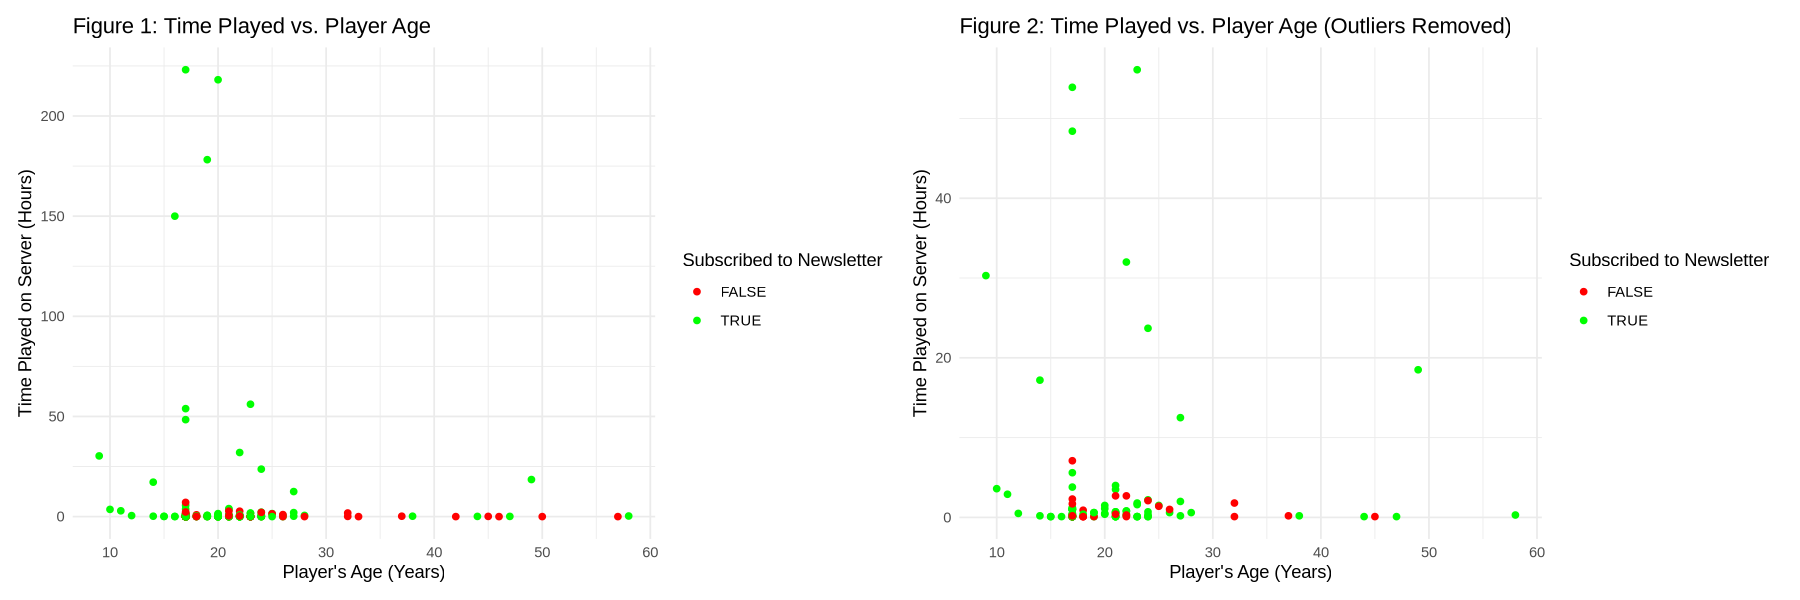

In [7]:
# Set-up
options(repr.plot.width = 15, repr.plot.height = 5)
library(patchwork)

# Remove NA values from data
players <- players |> 
  filter(!is.na(Age), !is.na(played_hours))

# Graph the relationship between time played, player age, and subscription status
time_age_1 <- players |>
  ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point() +
    labs(title = "Figure 1: Time Played vs. Player Age",
       x = "Player's Age (Years)", 
       y = "Time Played on Server (Hours)",
       color = "Subscribed to Newsletter") +
  scale_color_manual(values = c("red", "green")) +
  theme_minimal()

# Remove extreme outliers from the data
played_hours_trimmed <- players |>
  filter(played_hours <= 100) |>
  filter(played_hours > 0)

# Graph the relationship again with the trimmed data
time_age_2 <- played_hours_trimmed |>
  ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point() +
    labs(title = "Figure 2: Time Played vs. Player Age (Outliers Removed)",
       x = "Player's Age (Years)", 
       y = "Time Played on Server (Hours)",
       color = "Subscribed to Newsletter") +
  scale_color_manual(values = c("red", "green")) +
  theme_minimal()

# Print graphs side-by-side
time_age_1 + time_age_2

**Figure 1: Time played vs. Player age scatterplot**
- We first started by creating a scatterplot by graphing `played_hours` against `Age`. We coloured the points red or green based on the value of `subscribe`.
- We found that almost all of the points were near zero on the y-axis and that more points were closer to zero on the x-axis as well.
- There were some high outliers of `played_hours` in this graph that made the rest of the values difficult to see.
- We were unable to make any conclusions from this graph.

**Figure 2: Time played vs. Player age scatterplot (outliers removed)**
- To create this graph, we removed all points where `played_hours` exceeded 100 to get rid of the outliers.
- What we found after zooming in was that the majority of the data actually sat below 10 hours on the y-axis.
- We found that there was a cluster of points between 0-10 hours on the y-axis and between 10-30 years on the x-axis.

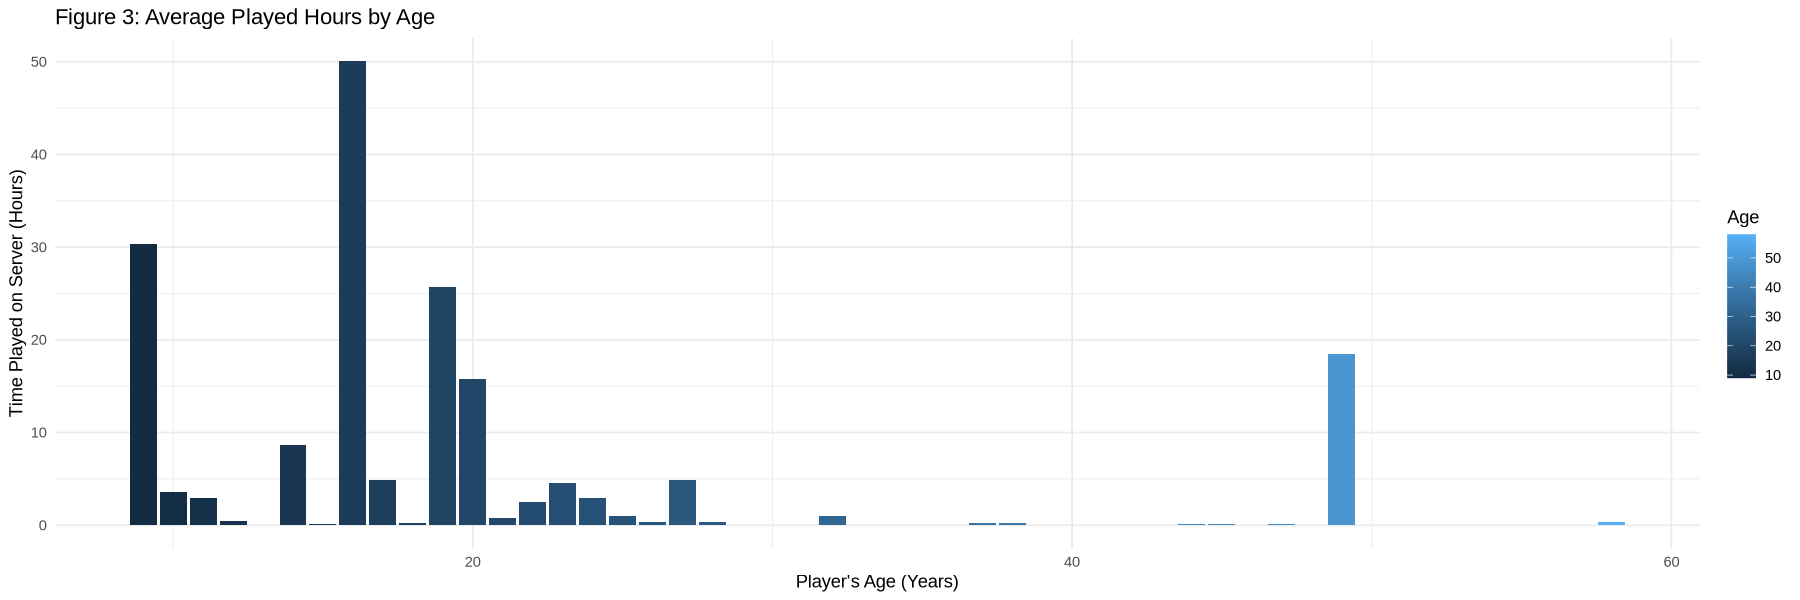

In [8]:
time_age_3 <- ggplot(players, aes(x = Age, y = played_hours, fill = Age)) +
  geom_bar(stat = "summary", fun = "mean") +
  labs(
    x = "Player's Age (Years)",
    y = "Time Played on Server (Hours)",
    title = "Figure 3: Average Played Hours by Age"
  ) +
  theme_minimal()

time_age_3

**Figure 3: Average played hours by age**
- We created a second visualization to compare the mean played hours of players in each age group.
- We found that players 20 years of age or younger played the most hours on average.
- By looking at the raw data, we notice that there is one 49 year old who played 18.5 hours, explaining our outlier.

## 5. Data Analysis

- We first set a random seed to make our results reproducible, and loaded the R packages.
- We use `initial_split()` to split the original `players` data into a 75% training set and a 25% testing set.
- We create a recipe that specifies the response variable `subscriber` and predictors, and applied `step_scale()` and `step_center()` to standardize all predictor variables. Therefore, the distance between data points will not be dominated by the variables with larger numeric scales. We pass the training data as the data argument of the recipe.
- We made a model specification using `nearest_neighbor()` with neighbors (`k`) equals `tune()`.
- We set a range of candidates *k* values using `tibble` function.
- We created 5-fold cross-validation objects with `vfold_cv()` split up the training data for cross-validation.
- Add the recipe and model specification to a `workflow()`, and use the `tune_grid` function on the train/validation splits to estimate the classifier accuracy for a range of *k* values.
- We picked the value of `k` with the highest mean accuracy (which was 6) and made a new model with this best `k`.
- We retrain the classifier using the fit function.
- We generated predictions for the testing set and used `metrics()`, `precision()`, `recall()`, and `conf_mat()` to compute overall accuracy, precision, recall, and the confusion matrix. These data help evaluate how well the model did on predicting.

In [9]:
set.seed(2025)
library(rsample)
library(tidyverse) 
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



In [10]:
# Split the data
players_split <- initial_split(players, prop = 0.75 , strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

In [11]:
# Find best k
players_recipe <- recipe(subscribe ~ ., data = players) |>   
step_scale(all_predictors()) |>   
step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>   
set_engine("kknn") |>   
set_mode("classification")

players_vfold <- vfold_cv(players, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))


knn_results <- workflow() |>   
add_recipe(players_recipe) |>   
add_model(knn_spec) |>   
tune_grid(resamples = players_vfold, grid = k_vals) |>   
collect_metrics()


accuracies <- knn_results |>   
filter(.metric == "accuracy")

best_k <- accuracies |>         
arrange(desc(mean)) |>         
head(1) |>         
pull(neighbors) 

best_k

[1] 6

In [12]:
# Train new model with the best k
knn_new_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6)|>   
set_engine("kknn") |>   
set_mode("classification")

knn_fit <- workflow() |>   
add_recipe(players_recipe) |>   
add_model(knn_new_spec) |>   
fit(data = players_train)

players_test_predictions <- predict(knn_fit, players_test) |>   
bind_cols(players_test)

accuracy <- players_test_predictions|>
metrics(truth = subscribe, estimate = .pred_class) |>   
filter(.metric == "accuracy")

accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6122449


In [13]:
# Check level
level <- players_test_predictions |> 
pull(subscribe) |> 
levels()

level

[1] "FALSE" "TRUE"

In [14]:
# Precision
precision <- players_test_predictions|>
precision(truth = subscribe, estimate = .pred_class, event_level = "second")

precision

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7931034


In [15]:
# Recall
recall <- players_test_predictions|>
recall(truth = subscribe, estimate = .pred_class, event_level = "second")

recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6388889


In [16]:
# Confusion
confusion <- players_test_predictions |>              
conf_mat(truth = subscribe, estimate = .pred_class) 

confusion

          Truth
Prediction FALSE TRUE
     FALSE     7   13
     TRUE      6   23

## 6. Analysis Visualization

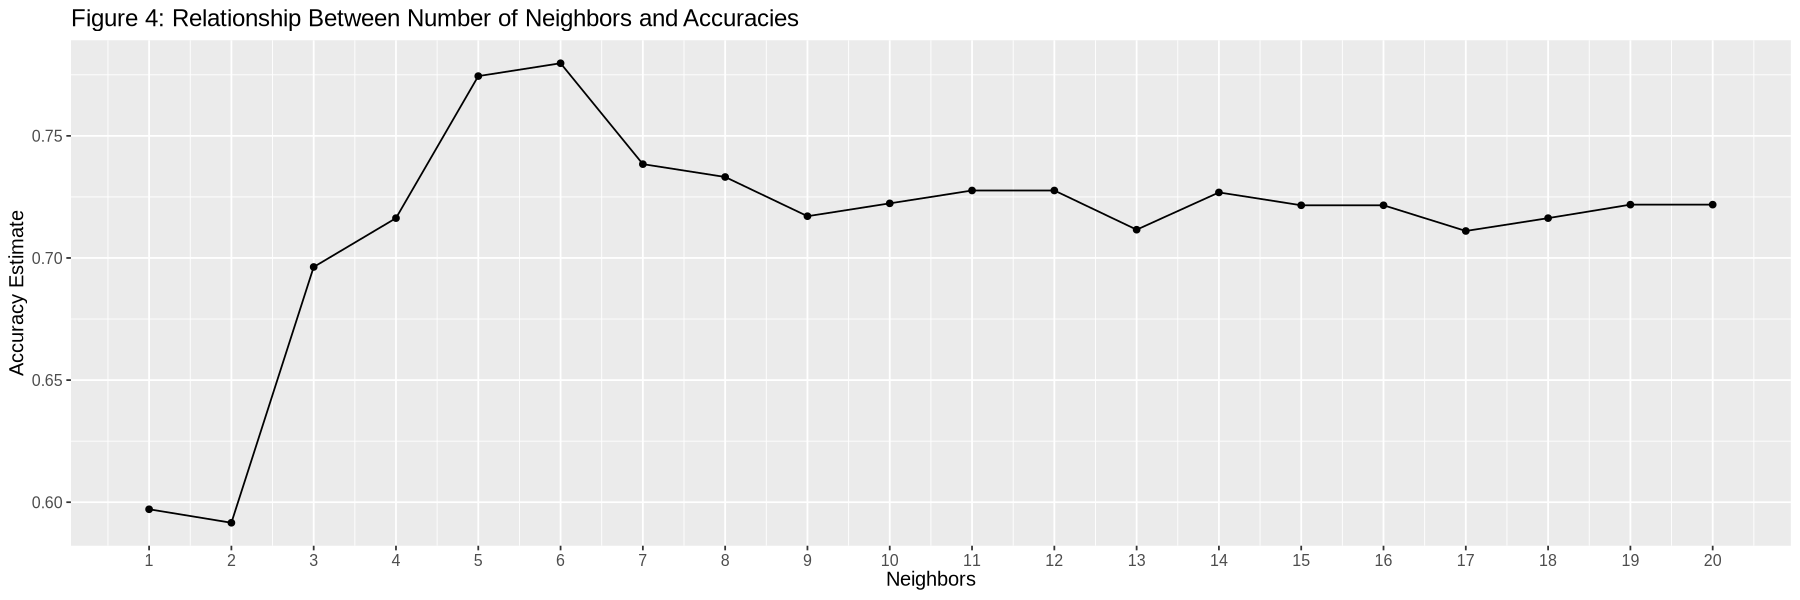

In [17]:
# Visualize accuracy for different k using cross validation 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +   
geom_point() +   
geom_line() +   
labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("Figure 4: Relationship Between Number of Neighbors and Accuracies")+
scale_x_continuous(breaks = 1:20)+
theme(text = element_text(size = 12))

accuracy_vs_k

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


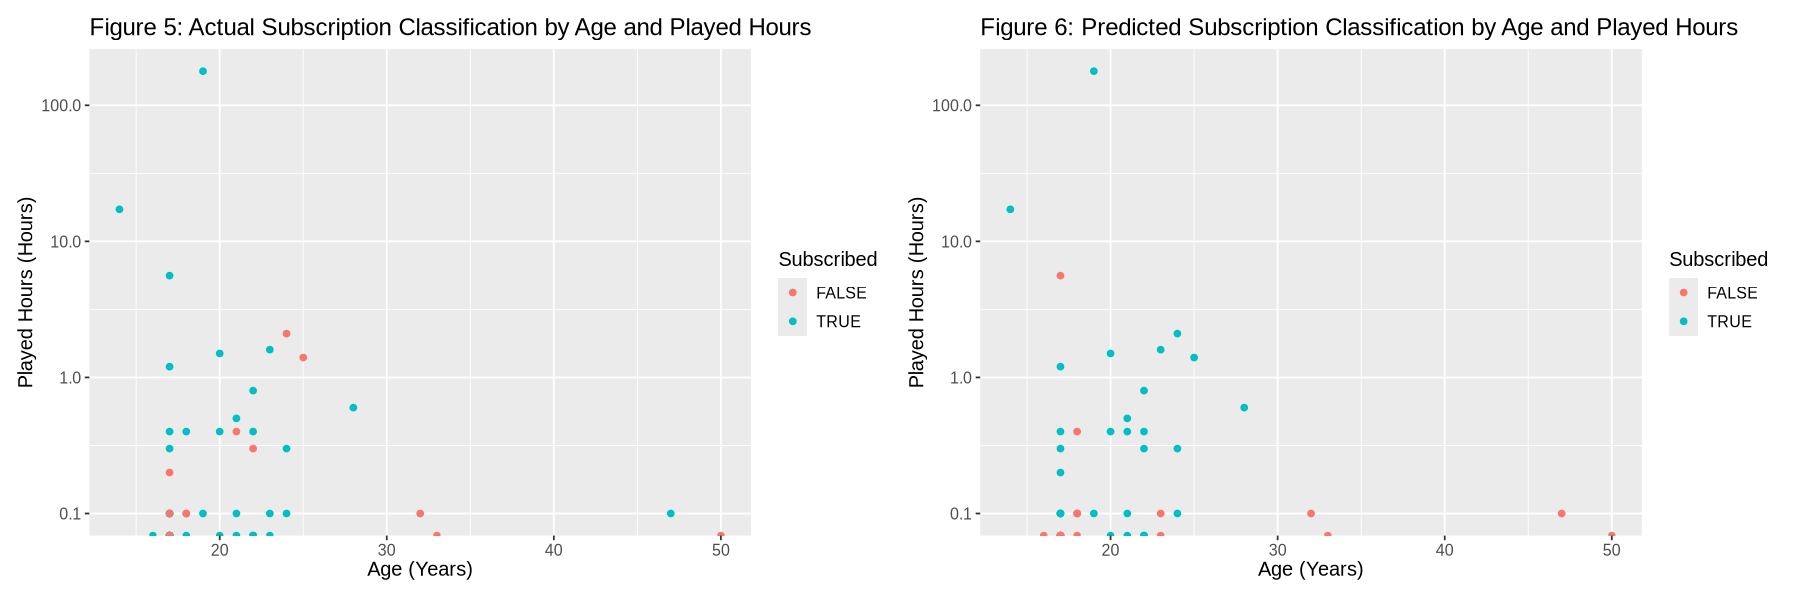

In [18]:
library(patchwork)
options(repr.plot.width = 15, repr.plot.height = 5)

true_classification <- ggplot(players_test_predictions, aes(x = Age, y = played_hours, color = subscribe))+
geom_point() +
labs(x = "Age (Years)", y = "Played Hours (Hours)", color = "Subscribed") +
ggtitle("Figure 5: Actual Subscription Classification by Age and Played Hours")+
scale_y_log10()+
theme(text = element_text(size = 12))

predict_result <- ggplot(players_test_predictions, aes(x = Age, y = played_hours, color = .pred_class))+
geom_point() +
labs(x = "Age (Years)", y = "Played Hours (Hours)", color = "Subscribed") +
ggtitle("Figure 6: Predicted Subscription Classification by Age and Played Hours")+
scale_y_log10()+
theme(text = element_text(size = 12))

true_classification + predict_result

# <u>Discussion<u>

## Summary

In this group project, we aim to explore whether a player’s age and their total playtime can be used to predict their likelihood of subscribing to a game-related newsletter. First, we download and read the dataset `players.csv`. After cleaning the data by selecting relevant variables and removing NA values, we calculate summary statistics for `Age`, `played_hours` and `subscribe`. Next, we visualize the relationships between time played, player's age and subscription status. The exploratory analysis reveals a heavily right-skewed distribution of players' total playtime, since the majority of players record very low playtime, often close to zero hours, and only a small number of them contribute extremely high playtime. In addition to that, age also shows little visible relationship with either playtime or subscription status. Then we train a K-nearest neighbors classification model. Our results show that the model achieves a test accuracy of approximately 61%, with a precision of 79% and a recall of 64%. Overall, the model is able to capture some relationships in the data but struggles to reliably distinguish subscribers from non-subscribers. While a player's age and their total playtime contain some information related to subscription behavior, they do not provide very strong predictive power.

## Expectations vs. Results

Before conducting the analysis, we expected to find the relationship between a player’s age, their total playtime and their likelihood of subscribing to a game-related newsletter. We assumed that players who spent more time playing the game would be more engaged in games overall. Therefore, they were more likely to subscribe to a game-related newsletter. Similarly, we expected age to also have a significant impact on this. Perhaps older players were more consistent gamers, so they would subscribe to a game-related newsletter. These assumptions shaped our initial hypothesis that both age and total playtime would help distinguish subscribers from non-subscribers.

However, the results do not fully support our expectations. The exploratory visualizations show that total playtime is extremely right-skewed, with most players recording very short playtime. Because of this, there is not enough variation in the data to form strong patterns that can separate subscribers from non-subscribers. Additionally, age does not show a clear and strong relationship with respect to subscription status as well. We can see that players of all ages cluster near the low playtime values. These findings suggest that the predictors we choose may not be very effective in predicting a player's subscription status. The performance of our K-nearest neighbors classification model confirms these observations. While the model achieves a relatively high precision of nearly 80%, its accuracy and recall are noticeably low. To conclude, the results highlight that the predictive power of age and playtime in predicting subscription status is limited.

## Impact

The findings of this project are meaningful to the research group. The results suggest that players' age and total playtime are not strong indicators of whether a player will subscribe to a game-related newsletter. In this case, if the research group aims at figuring out the player characteristics and behaviours that are most predictive of subscribing to a game-related newsletter, they are supposed to consider other variables. Recognizing the limitation that occurs in our project also encourages the group to think of collecting richer data in future studies. For instance, other behavioral variables, such as personal interest, may better reflect a player’s interest in ongoing game engagement, thus affecting their likelihood of subscribing to a game-related newsletter. 

Moreover, the modeling process itself has practical implications. By understanding the advantages of modeling, the research group can use it as an effective predictive tool for further work, helping them process more complex data in the future.

## Future Questions

This project makes us consider other directions for future exploration. One important direction for future work is to explore how the model’s accuracy can be improved. Since age and total playtime show only weak relationships with the subscription status, it will be valuable to investigate whether adding additional predictors can strengthen the model. For instance, the `players.csv` dataset also contains information such as experience level and gender, which may reveal more meaningful relationships with the subscription status. We can take advantage of information in the `sessions.csv` dataset as well. These additional predictors may make a difference to our K-nearest neighbors model.

Another direction of exploration is to build a more effective model that is able to make better predictions by applying different modeling techniques. The model we use in the project is K-nearest neighbors classification model, which is simple but may not be suitable for imbalanced datasets or weakly structured predictors. Our future work can involve training other models that are more flexible. Comparing multiple models can help uncover which prediction methods are most reliable for this project, potentially leading to better predictions.

In conclusion, the future work should focus on identifying richer features and more suitable models to achieve higher predictive accuracy and recall, better capturing the factors that influence whether players subscribe to a game-related newsletter.